# Моделирование и проверка гипотез

**Цель:** статистически проверить гипотезы, сформулированные по итогам углубленного анализа, а также построить интерпретируему модель для выявления факторов, влияющих на выручку.
  
**Источник данных:** data/flipkard_with_features.csv

## 1. Загрузка данных и подключение библиотек

In [45]:
#подключение библиотек

#работа с таблицами
import pandas as pd
import numpy as np

#визуализация графиков
import matplotlib.pyplot as plt
import seaborn as sns

#статистические тесты
from scipy import stats

#машинное обучение и подготовка данных
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

#классическая статистическая регрессия
import statsmodels.api as sm

In [2]:
#загрузка данных
df = pd.read_csv('../data/flipkard_with_features.csv')
df.head()

,product_id,product_name,category,brand,seller,seller_city,price,discount_percent,final_price,rating,...,rating_segment,fast_delivery,long_warranty,heavy_product,returnable,high_rating,popular_product,trusted_seller,avg_revenue_by_category,avg_units_sold_by_brand
0,FKP0000001,Adidas Ultra 664,Toys,Adidas,MegaStore,Hyderabad,35547.34,15,30215.24,1.9,...,low,0,1,1,1,0,1,0,59.742742,2548.707820
1,FKP0000002,LG Series 124,Fashion,LG,ValueKart,Mumbai,30693.79,10,27624.41,3.2,...,mid,0,0,0,1,0,1,0,59.479754,2507.660804
2,FKP0000003,Redmi Model 35,Beauty,Redmi,SmartDeals,Ahmedabad,51214.50,40,30728.70,4.4,...,high,0,1,0,0,0,0,0,60.017435,2494.449813
3,FKP0000004,Sony Edition 769,Toys,Sony,UrbanRetails,Delhi,33168.49,30,23217.94,2.8,...,low,1,1,1,0,0,0,0,59.742742,2483.466616
4,FKP0000005,Boat Prime 291,Home & Kitchen,Boat,RetailHub,Pune,14181.34,0,14181.34,3.7,...,mid,0,0,0,1,0,1,1,59.731439,2528.777862


## 2. Подготовка к моделированию

In [12]:
#отбираем нужные столбцы
features = ['price_segment', 'rating_segment', 'delivery_days', 'listing_month']
target = 'revenue_m'

df_model = df[features + [target]].copy()

In [13]:
#кодирование категорий
df_model = pd.get_dummies(df_model, drop_first=True).astype(int)

df_model.head()

,delivery_days,listing_month,revenue_m,price_segment_low,price_segment_mid,rating_segment_low,rating_segment_mid
0,11,4,1,0,1,1,0
1,3,5,74,0,1,0,1
2,5,9,73,0,0,0,0
3,1,8,40,0,1,1,0
4,7,8,65,1,0,0,1


In [32]:
#формируем матрицу признаков и целевую переменную
x = df_model.drop(columns='revenue_m')
y = df_model['revenue_m']

## 3. Проверка гипотезы о сезонности

### 3.1 Проверка гипотезы о сезонности (ANOVA)  
  
H0: Средняя выручка по месяцам одинаковая  
H1: Хотя бы в одном месяце средняя выручка отличается

In [17]:
#разбиваем выручку на группы по месяцам 
groups = []
for month in sorted(df['listing_month'].unique()):
    groups.append(df[df['listing_month'] == month]['revenue_m'])

#применяем ANOVA
f_stat, p_value = stats.f_oneway(*groups)

print(f'F-statistic: {f_stat:.2f}')
print(f'P-value: {p_value:.5f}')

F-statistic: 0.43
P-value: 0.94373


In [18]:
if p_value < 0.05:
    print('Различие статистически значимо')
else:
    print('Статистически значимого различия нет')

Статистически значимого различия нет


**Вывод:**  
В результате проведения однофакторного дисперсионного анализа (ANOVA)  
статистически значимых различий между средними значениями выручки по месяцам обнаружено не было (p-value > 0.05).

Гипотеза о наличии выраженной сезонности продаж на данном этапе **не получила статистического подтверждения**.

### 3.2 Дополнительная проверка локальной гипотезы о февральском спаде 

Несмотря на отсутсвие общей статистической значимой сезонности, визуальный анализ показал выраженное снижение выручки в феврале по сравнению с январем.

В связи с этим была сформулирована уточняющая гипотеза:

H0: Средняя выручка в феврале не ниже, чем в январе  
H1: Средняя выручка в феврале статистически значимо ниже, чем в январе
  
Визуальный анализ сезонности был проведён на этапе [углубленного анализа](03_feature_engineering.ipynb)(см. раздел 4.3). 
Здесь проведём **статистическую проверку гипотезы** для подтверждения количественно.

In [ ]:
#статистическая проверка
jan = df[df['listing_month'] == 1]['revenue_m']
feb = df[df['listing_month'] == 2]['revenue_m']

#проверяем непараметрическим тестом (Mann–Whitney test)
stat, p_value = stats.mannwhitneyu(jan, feb, alternative='greater')

print(f'P-value: {p_value:.5f}')

if p_value < 0.05:
    print('Есть статистические основания утверждать, что январь выше февраля')
else:
    print('Недостаточно статистический оснований утвержать, что январь выше февраля')

P-value: 0.69168
Недостаточно статистический оснований утвержать, что январь выше февраля


In [27]:
#средняя выручка по месяцам
monthly_mean = df.groupby('listing_month')['revenue_m'].mean().sort_index()
monthly_mean

listing_month
1     60.080478
2     60.097979
3     59.174361
4     59.244216
5     59.330384
6     59.012586
7     59.778928
8     59.424417
9     59.971732
10    58.836231
11    59.999384
12    59.400499
Name: revenue_m, dtype: float64

In [30]:
#медианная выручка по месяцам
monthly_median = df.groupby('listing_month')['revenue_m'].median().sort_index()
monthly_median

listing_month
1     43.339055
2     44.267791
3     43.035762
4     42.973936
5     42.813446
6     42.530803
7     43.401158
8     43.568169
9     43.645703
10    42.777844
11    43.833862
12    42.734990
Name: revenue_m, dtype: float64

**Вывод:** 
Статистическая проверка показала p-value = 0.69168, что значительно выше 0.05.  
Средние и медианные значения выручки в январе и феврале почти одинаковы.
 
**гипотеза о февральском сезонном спаде не подтвердилась** – в данных текущего периода нет статистически значимого падения выручки после января.


### 3.3 Вывод о гипотезе сезонности

На графике суммарной выручки по месяцам ([углубленный анализ](03_feature_engineering.ipynb) (см. раздел 4.3)) наблюдается заметное снижение в феврале.  
Однако статистический тест и анализ средних значений показывают, что **средняя выручка практически не изменилась**.  

Причины такого расхождения:
1. Суммарная выручка зависит от количества заказов и активных товаров в месяце. Февраль — короткий месяц – меньше транзакций.
2. Средние значения и тесты оценивают распределение по отдельным объектам, а не суммарный результат, поэтому статистически значимого спада нет.
3. Визуально видимый «провал» на суммарном графике может быть следствием сезонных факторов и случайных колебаний объема продаж, а не падения эффективности.

**Вывод:**  
Февральский спад на суммарном графике — это визуальный эффект, а не реальный статистически значимый провал выручки. Аналитические меры и рекомендации лучше строить на основе средних значений и статистической проверки.


## 4. Проверка гипотезы о влиянии скорости доставки 

H0: Скорость доставки не оказывает статистически значимого влияния на выручку при учете ценового сегмента, категории товара и сезона  
H1: Скорость доставки оказывает статистически значимого влияния на выручку при учете ценового сегмента, категории товара и сезона  

### 4.1 Множественная линейная регрессия 

Используем statsmodels, чтобы:
- получить коэффициенты для каждого признака,
- посмотреть их p-value для проверки статистической значимости,
- интерпретировать влияние скорости доставки при контроле других факторов.

In [36]:
#добавляем константу для модели
x_sm = sm.add_constant(x)

#строим моедль OLS
model = sm.OLS(y, x_sm).fit()

#выводим сводку модели
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              revenue_m   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     7065.
Date:                Thu, 22 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:06:40   Log-Likelihood:            -4.1669e+05
No. Observations:               80000   AIC:                         8.334e+05
Df Residuals:                   79993   BIC:                         8.335e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 98.2231      0.558    176.150      0.000      97.130      99.316
delivery_days         -0.0180      0.049     -0.364      0.716      -0.115       0.079
listing_month          0.0223      0.045      0.491      0.623      -0.067       0.111
price_segment_low    -78.8924      0.383   -205.877      0.000     -79.643     -78.141
price_segment_mid    -39.4513      0.383   -102.954      0.000     -40.202     -38.700
rating_segment_low     0.3828      0.379      1.010      0.312      -0.360       1.125
rating_segment_mid     0.1326      0.437      0.304      0.761      -0.723       0.989
==============================================================================
Omnibus:                     5502.337   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7771.922
Skew:                           0.593   Prob(JB):                         0.00
Kurtosis:                       3.962   Cond. No.                         40.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Вывод:** Ценовой сегмент — ключевой фактор, скорость доставки и рейтинг не оказывают значимого эффекта. Модель объясняет ~34.6% вариации выручки.

### 4.2 Визуализация эффектов

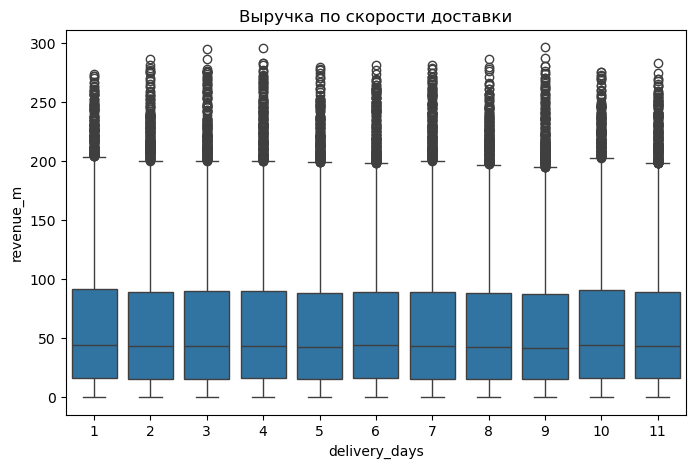

In [40]:
plt.figure(figsize=(8,5))
sns.boxplot(x='delivery_days', y='revenue_m', data=df)
plt.title("Выручка по скорости доставки")
plt.show()

### 4.3 Вывод о гипотезе влияния скорости доставки

По результатам множественной регрессии (OLS), где учтены ценовой сегмент, рейтинг товара и месяц размещения:

- **Коэффициент для скорости доставки**: -0.018, **p-value = 0.716**  
  → эффект статистически **не значим**, то есть быстрая доставка **не оказывает заметного влияния на выручку**, когда контролируются другие факторы.
  
- **Интерпретация для бизнеса**:  
  - Ценовой сегмент оказывает гораздо более сильное влияние на выручку.  
  - Инвестиции в ускорение доставки не принесут значимого увеличения дохода, по крайней мере, в текущем ассортименте и условиях.  
  - Скорость доставки может играть роль для удовлетворенности клиентов, но **на уровне выручки прямого эффекта не наблюдается**.

## 5. Оценка качества модели

In [49]:
#разделяем данные на тренировочную и тестовую выборки 
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

#обучаем модель на тренировочной выборке
model = LinearRegression()
model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
#делаем предсказание на тестовой выборке
y_pred = model.predict(x_test)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R²: 0.3384981621151151
MAE: 33.33003433986366


### Вывод по результатам оценки качества модели

- Построенная линейная модель объясняет примерно 34% вариации выручки (R² = 0.34), что указывает на умеренную предсказательную способность.  
- Средняя абсолютная ошибка предсказаний составляет 33.3 единицы, что отражает наличие случайного шума и влияния факторов, не включённых в модель.  
- Несмотря на умеренный R², модель полезна для **интерпретации факторов**, влияющих на выручку



# Общий вывод по этапу моделирования

1. **Сезонность выручки**  
   - Однофакторный ANOVA-тест показал, что статистически значимой сезонности по месяцам **не выявлено** (p-value > 0.05).  
   - Проверка гипотезы о снижении выручки в феврале также не подтвердилась (p-value = 0.69168).  
   - Визуальный спад на суммарных графиках объясняется коротким февральским месяцем и случайными колебаниями объема продаж, а не реальным снижением средней выручки.

2. **Факторы, влияющие на выручку (множественная регрессия)**  
   - Модель учитывала ценовой сегмент, рейтинг товара, месяц размещения и скорость доставки.  
   - **Ключевой фактор:** ценовой сегмент оказывает значимое влияние на выручку.  
   - **Скорость доставки** и рейтинг статистически значимы **не были** (p-value > 0.7).  
   - Прямое влияние скорости доставки на выручку отсутствует, инвестиции в ускорение доставки не дадут заметного эффекта на доход.

3. **Качество модели**  
   - Модель объясняет ~34% вариации выручки (R² = 0.34), что отражает умеренную предсказательную способность.  
   - Средняя абсолютная ошибка ≈ 33.3 единицы, указывая на наличие нерегламентированного шума и факторов, не включённых в модель.  
   - Несмотря на умеренный R², модель полезна для **интерпретации влияния факторов** на выручку и формирования управленческих решений.

**Вывод для бизнеса:**  
Средняя выручка мало зависит от сезонности и скорости доставки, но сильно коррелирует с ценовым сегментом. Приоритетные направления для оптимизации дохода — корректировка ассортимента и ценовой политики.